In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle
from graph_creator.utilities import make_node_edge_df
from graph_creator.SubgraphIsomorphismChecker import IsomorphicGrapCoverageCounter
from graph_creator.ActorGraph import ActorType
from glob import glob

os.chdir('../..')
print(os.getcwd())
from configs.subgraphs.subgraphs import (G_lead_vehicle_in_front_with_neighbor_vehicle, 
    G_lead_neighbor_opposite_vehicle, 
    G_cut_out_intersection
)
# from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map



/home/tmuehlen/repos/graph_coverage


14099

In [ ]:
graph_paths_carla = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*pkl")
len(graph_paths_carla)

graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*pkl")
graph_paths_argo = glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*pkl")

len(graph_paths_argo)

15591

In [18]:
graph_setting = "graph_setting_1_50_50_10_20_20_4_4_4"
carla_graph_dir = f'carla_actor_{graph_setting}'
argoverse_graph_dir = f'argoverse_actor_{graph_setting}'
graph_paths_carla = glob(f"/home/tmuehlen/repos/graph_coverage/actor_graphs/{carla_graph_dir}_components_nx/*.pkl")
print(len(graph_paths_carla))
graph_paths_argo = glob(f"/home/tmuehlen/repos/graph_coverage/actor_graphs/{argoverse_graph_dir}_components_nx/*.pkl")
print(len(graph_paths_argo))

141954
235380


### Start comparing graphs by randomly picking some:

In [ ]:
# Define a random set of coverage situations with 3 nodes each

idxs = random.sample(list(range(len(graph_paths_carla))), 10)

coverage_graphs = {}
cov_data = {}

for idx in idxs:
    graph_path = graph_paths_carla[idx]
    with open(graph_path, "rb") as file:
        ag_nx = pickle.load(file)
    #random.sample(ag_nx.nodes, 3)
    if ag_nx.number_of_nodes() > 2:
        coverage_graphs[idx] = ag_nx.subgraph(random.sample(list(ag_nx.nodes), 3))
        # cov_data[idx] = []

isom_cov_counter = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_carla[:100], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter.count_isomorphic_graphs()
cov_data_df = isom_cov_counter.cov_data_df

cov_data_df.mean(numeric_only=True)
cov_data_df.groupby(list(cov_data_df.columns[:(cov_data_df.shape[1] - 3)]), as_index=False).size()
coverage_graphs

Checking isomorphic graphs: 100%|██████████| 100/100 [00:00<00:00, 250.35it/s]


{12778: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbe1e38e0>,
 279: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda587c0>,
 8326: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda5a8f0>,
 1903: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda5aa10>,
 11423: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda59900>,
 12200: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda595a0>,
 10630: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda592a0>,
 7264: <networkx.classes.multidigraph.MultiDiGraph at 0x79efbda58b20>}

### Use hand crafted subgraphs for coverage

In [5]:
coverage_graphs = {}

coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle"] = G_lead_vehicle_in_front_with_neighbor_vehicle
coverage_graphs["lead_neighbor_opposite_vehicle"] = G_lead_neighbor_opposite_vehicle
coverage_graphs["cut_out_intersection"] = G_cut_out_intersection


In [7]:
n_check_graphs = 5000
isom_cov_counter_carla = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_carla[:n_check_graphs], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter_carla.count_isomorphic_graphs()
cov_data_df_carla = isom_cov_counter_carla.cov_data_df
cov_data_df_carla.head(10)

Checking isomorphic graphs: 100%|██████████| 5000/5000 [00:06<00:00, 793.75it/s] 


,lead_vehicle_in_front_with_neighbor_vehicle,lead_neighbor_opposite_vehicle,cut_out_intersection,degree,density,diameter,path
0,False,False,False,2.000000,1.000000,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,False,False,False,2.000000,1.000000,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
2,False,False,False,2.000000,1.000000,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
3,True,False,False,2.666667,0.666667,2,/home/tmuehlen/repos/graph_coverage/actor_grap...
4,False,False,False,3.200000,0.400000,3,/home/tmuehlen/repos/graph_coverage/actor_grap...
5,True,False,False,2.666667,0.666667,2,/home/tmuehlen/repos/graph_coverage/actor_grap...
6,True,False,False,3.333333,0.333333,4,/home/tmuehlen/repos/graph_coverage/actor_grap...
7,True,False,False,2.666667,0.666667,2,/home/tmuehlen/repos/graph_coverage/actor_grap...
8,False,False,False,2.000000,1.000000,1,/home/tmuehlen/repos/graph_coverage/actor_grap...
9,False,False,False,2.666667,0.666667,2,/home/tmuehlen/repos/graph_coverage/actor_grap...


In [8]:
isom_cov_counter_argo = IsomorphicGrapCoverageCounter(coverage_graphs, graph_paths_argo[:n_check_graphs], node_match = ["actor_type", "lane_change", "is_on_intersection"], edge_match = ["edge_type"])
isom_cov_counter_argo.count_isomorphic_graphs()
cov_data_df_argo = isom_cov_counter_argo.cov_data_df
cov_data_df_argo.head(5)

Checking isomorphic graphs: 100%|██████████| 5000/5000 [00:04<00:00, 1093.96it/s]


,lead_vehicle_in_front_with_neighbor_vehicle,lead_neighbor_opposite_vehicle,cut_out_intersection,degree,density,diameter,path
0,True,False,False,3.764706,0.117647,12,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,True,False,False,4.235294,0.132353,6,/home/tmuehlen/repos/graph_coverage/actor_grap...
2,True,False,False,4.000000,0.181818,6,/home/tmuehlen/repos/graph_coverage/actor_grap...
3,False,False,False,2.666667,0.666667,2,/home/tmuehlen/repos/graph_coverage/actor_grap...
4,False,False,False,3.000000,0.500000,3,/home/tmuehlen/repos/graph_coverage/actor_grap...


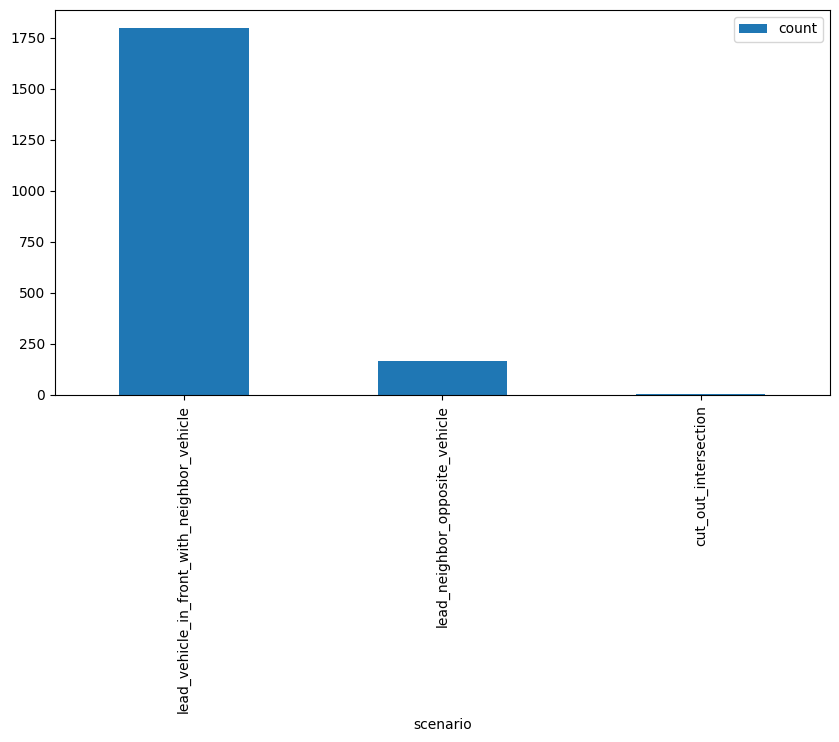

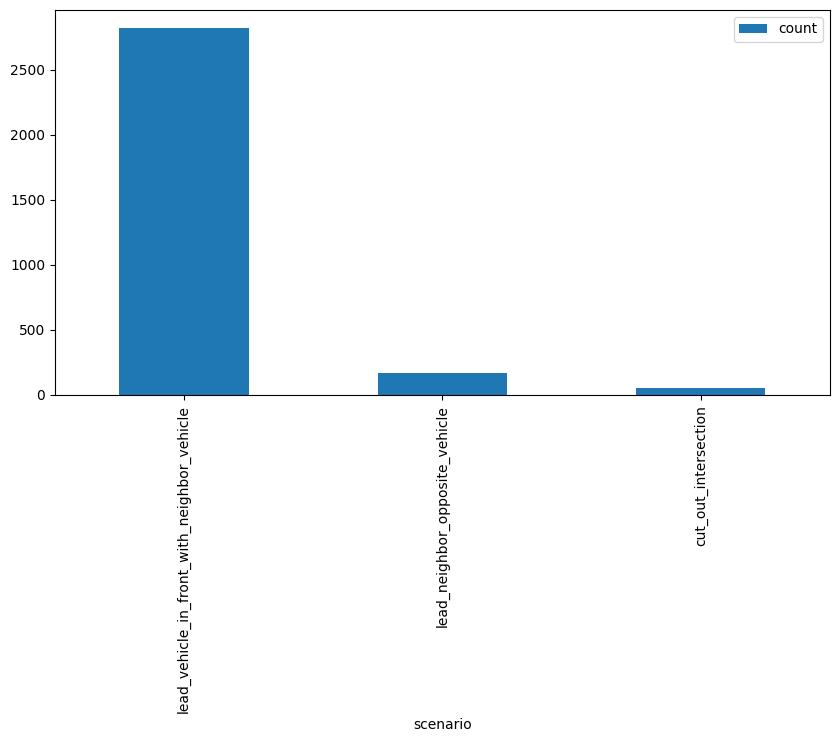

In [9]:
barchart_df = cov_data_df_carla[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df.plot(kind="bar", x="scenario", y="count", figsize=(10, 5))
plt.savefig('article/plots/subgraph_isomorphism_carla_coverage_barchart.png', dpi=300, bbox_inches='tight')
plt.show()
barchart_df = cov_data_df_argo[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df.plot(kind="bar", x="scenario", y="count", figsize=(10, 5))
plt.savefig('article/plots/subgraph_isomorphism_argo_coverage_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

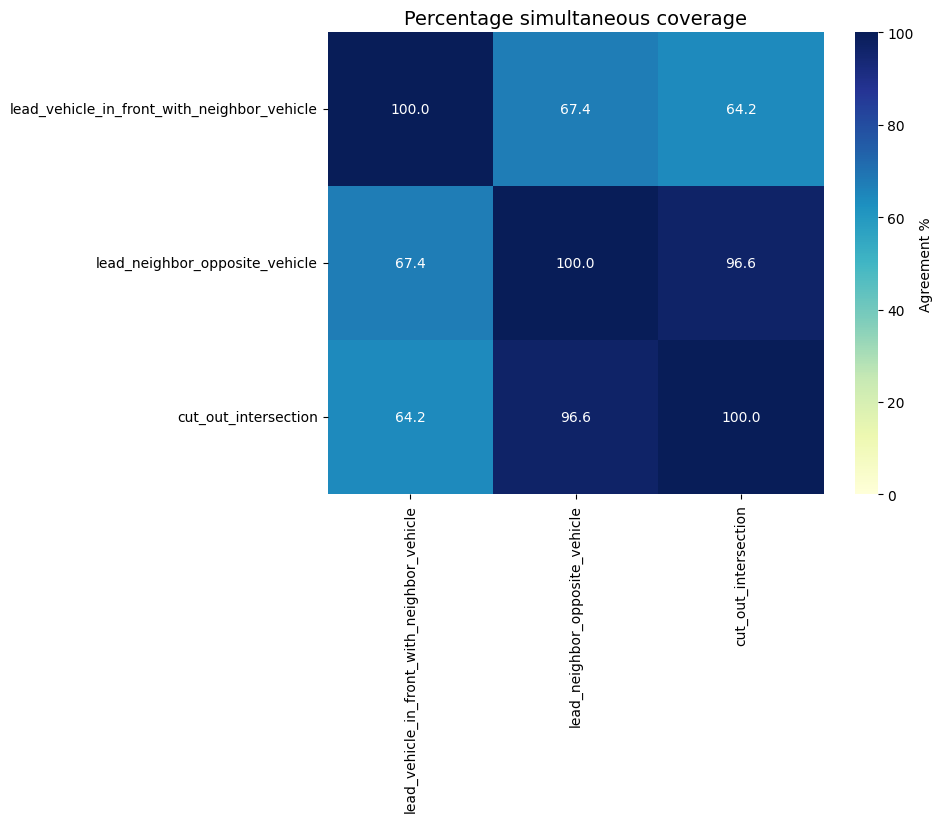

In [10]:
columns = list(coverage_graphs.keys())
# cov_data_df[coverage_graphs.keys()]
n_cols = len(columns)
agreement_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: 100% agreement with itself
            agreement_matrix[i, j] = 100
        else:
            # Calculate percentage of rows where both columns agree
            agreement = (cov_data_df_carla[col1] == cov_data_df_carla[col2]).sum() / len(cov_data_df_carla) * 100
            agreement_matrix[i, j] = agreement

# Create DataFrame for the heatmap
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=columns,
    columns=columns
)
agreement_df

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, 
            annot=True,  # Show percentages in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='YlGnBu',  # Color scheme
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'})
plt.title('Percentage simultaneous coverage', fontsize=14)
#plt.tight_layout()
plt.savefig('article/plots/subgraph_isomorphism_agreement_matrix_manual_scenarios_carla.png', dpi=300, bbox_inches='tight')
plt.show()

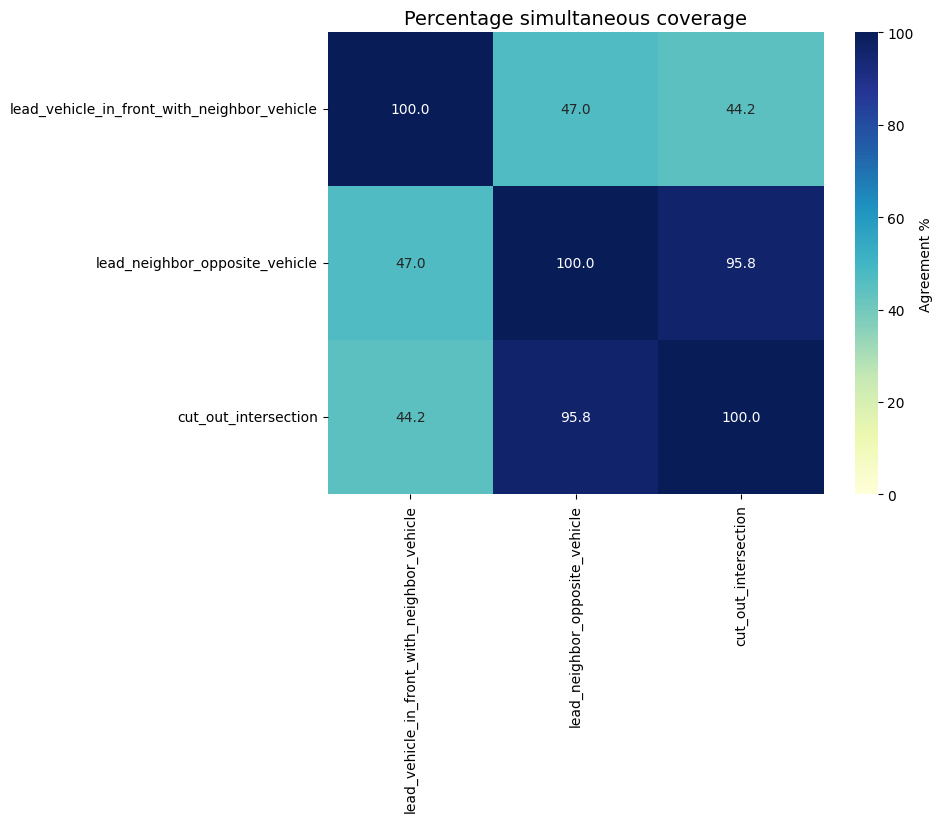

In [11]:
columns = list(coverage_graphs.keys())
# cov_data_df[coverage_graphs.keys()]
n_cols = len(columns)
agreement_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            # Diagonal: 100% agreement with itself
            agreement_matrix[i, j] = 100
        else:
            # Calculate percentage of rows where both columns agree
            agreement = (cov_data_df_argo[col1] == cov_data_df_argo[col2]).sum() / len(cov_data_df_argo) * 100
            agreement_matrix[i, j] = agreement

# Create DataFrame for the heatmap
agreement_df = pd.DataFrame(
    agreement_matrix,
    index=columns,
    columns=columns
)
agreement_df

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(agreement_df, 
            annot=True,  # Show percentages in cells
            fmt='.1f',   # Format to 1 decimal place
            cmap='YlGnBu',  # Color scheme
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'})
plt.title('Percentage simultaneous coverage', fontsize=14)
#plt.tight_layout()
plt.savefig('article/plots/subgraph_isomorphism_agreement_matrix_manual_scenarios_argo.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# latex table, not sure, if needed...
# groupby_df = cov_data_df_carla.groupby(list(cov_data_df_carla.columns[:(len(coverage_graphs.keys()))]), as_index=False).size()
# groupby_df.columns = groupby_df.columns.str.replace('_', ' ')
# latex_table = groupby_df.to_latex(index=False, caption='My Table', 
#                           label='tab:mytable', position='htbp')

# print(latex_table)

In [12]:
coverage_graph_names = list(coverage_graphs.keys())

100%|██████████| 5/5 [00:00<00:00, 264.46it/s]


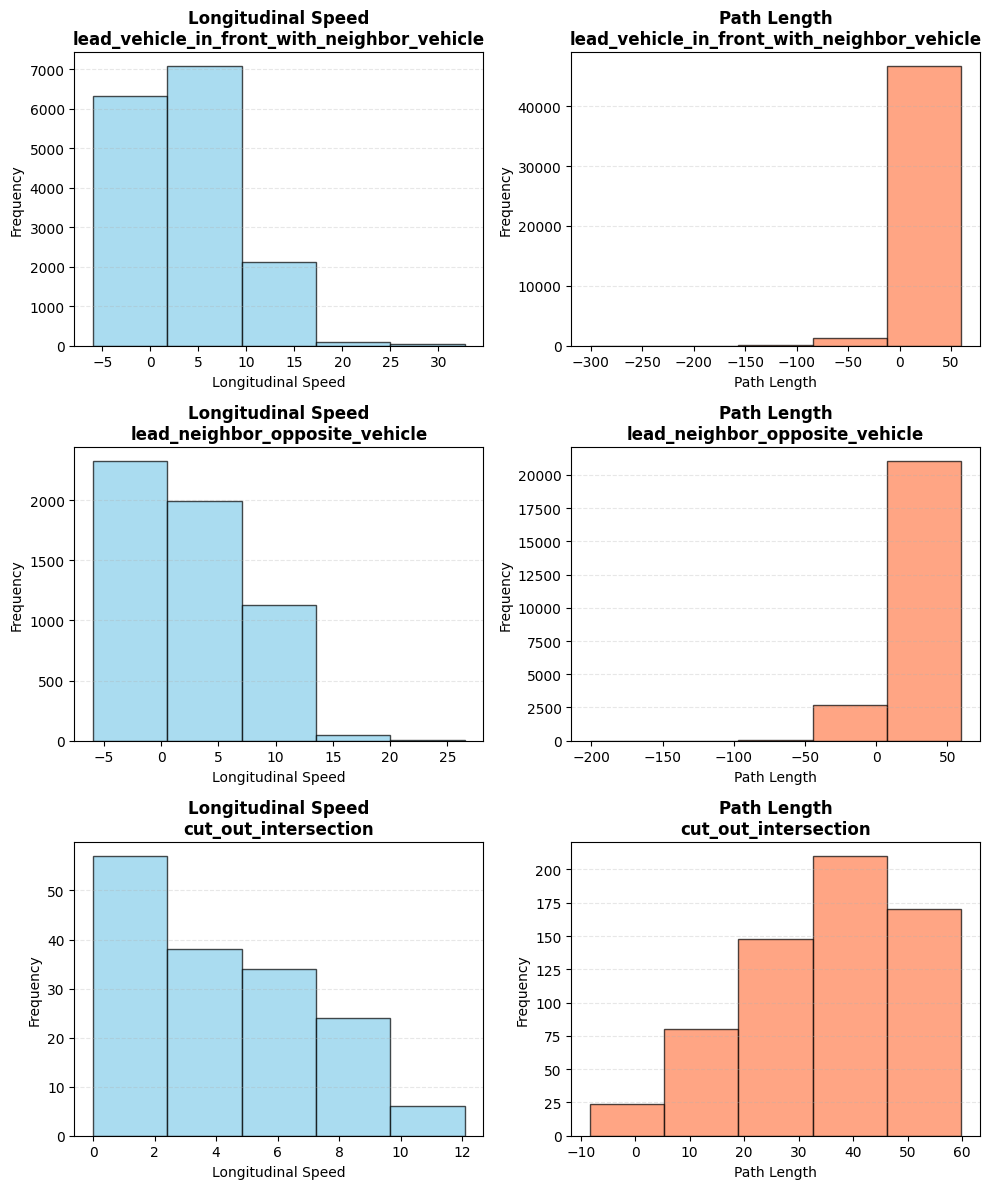

In [13]:
# Create figure with subplots: 2 rows, columns = number of coverage_graph_names
n_rows = len(coverage_graph_names)
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))


for row_idx, coverage_graph_name in enumerate(coverage_graph_names):
    scn_graph_paths = cov_data_df_carla[cov_data_df_carla[coverage_graph_name]].path.to_list()
    
    # Get the speed and distances for all of the paths
    node_dfs = []
    edge_dfs = []
    for scn_graph_path in tqdm(scn_graph_paths):
        with open(scn_graph_path, "rb") as file:
            ag_nx = pickle.load(file)
        node_df, edge_df = make_node_edge_df(ag_nx)
        node_df["path"] = scn_graph_path
        edge_df["path"] = scn_graph_path
        node_dfs.append(node_df)
        edge_dfs.append(edge_df)
    
    node_df = pd.concat(node_dfs)
    edge_df = pd.concat(edge_dfs)
    
    # Plot 1: Longitudinal Speed (top row)
    node_df.lon_speed.plot(kind="hist", bins=5, ax=axes[row_idx, 0],
                           color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, 0].set_title(f'Longitudinal Speed\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 0].set_xlabel('Longitudinal Speed', fontsize=10)
    axes[row_idx, 0].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 2: Path Length (bottom row)
    edge_df.path_length.plot(kind="hist", bins=5, ax=axes[row_idx, 1],
                             color='coral', edgecolor='black', alpha=0.7)
    axes[row_idx, 1].set_title(f'Path Length\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 1].set_xlabel('Path Length', fontsize=10)
    axes[row_idx, 1].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('article/plots/combined_distributions_plots_speed_distance_carla.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 49/49 [00:00<00:00, 375.85it/s]


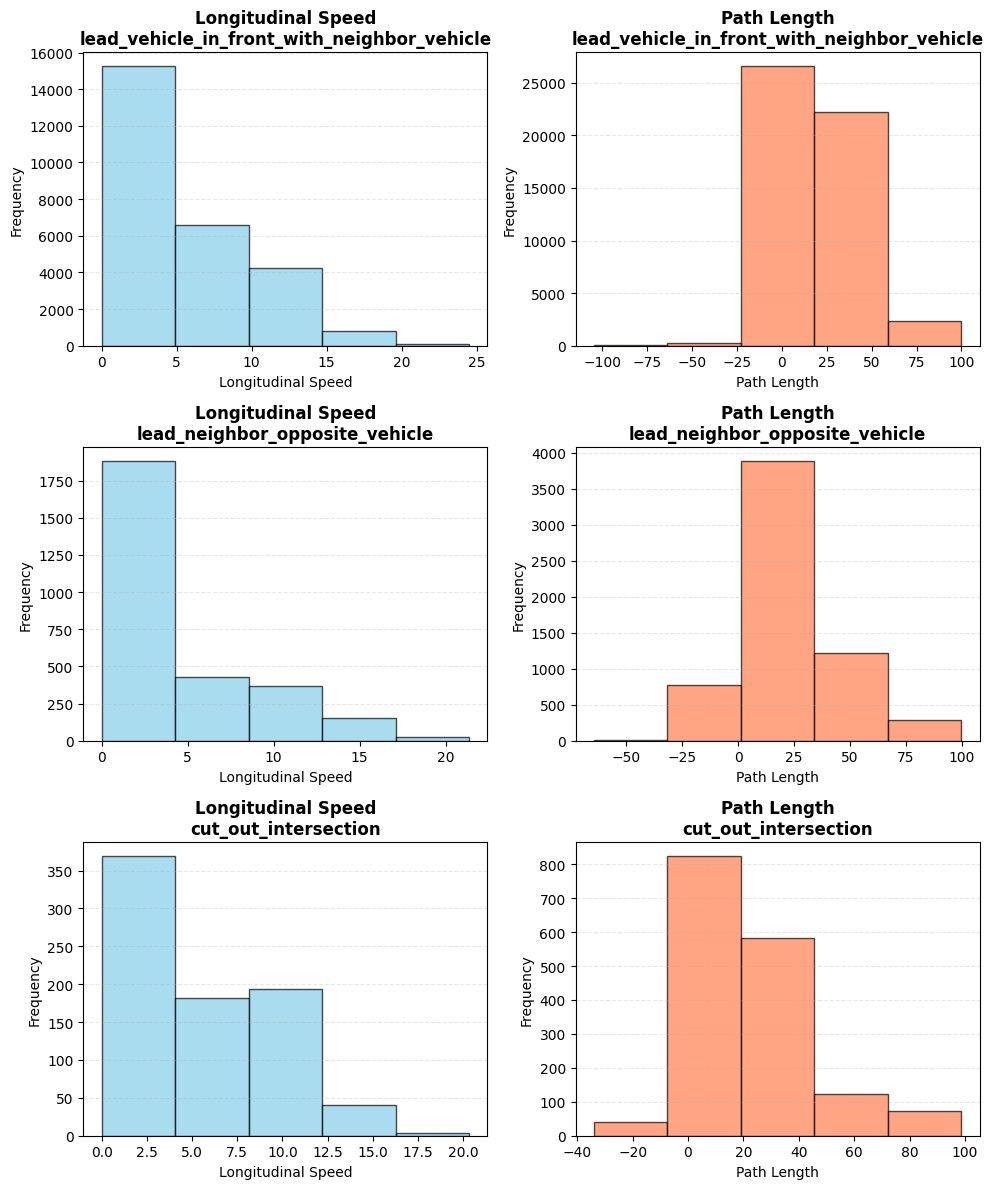

In [14]:
# Create figure with subplots: 2 rows, columns = number of coverage_graph_names
n_rows = len(coverage_graph_names)
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))


for row_idx, coverage_graph_name in enumerate(coverage_graph_names):
    scn_graph_paths = cov_data_df_argo[cov_data_df_argo[coverage_graph_name]].path.to_list()
    
    # Get the speed and distances for all of the paths
    node_dfs = []
    edge_dfs = []
    for scn_graph_path in tqdm(scn_graph_paths):
        with open(scn_graph_path, "rb") as file:
            ag_nx = pickle.load(file)
        node_df, edge_df = make_node_edge_df(ag_nx)
        node_df["path"] = scn_graph_path
        edge_df["path"] = scn_graph_path
        node_dfs.append(node_df)
        edge_dfs.append(edge_df)
    
    node_df = pd.concat(node_dfs)
    edge_df = pd.concat(edge_dfs)
    
    # Plot 1: Longitudinal Speed (top row)
    node_df.lon_speed.plot(kind="hist", bins=5, ax=axes[row_idx, 0],
                           color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, 0].set_title(f'Longitudinal Speed\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 0].set_xlabel('Longitudinal Speed', fontsize=10)
    axes[row_idx, 0].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Plot 2: Path Length (bottom row)
    edge_df.path_length.plot(kind="hist", bins=5, ax=axes[row_idx, 1],
                             color='coral', edgecolor='black', alpha=0.7)
    axes[row_idx, 1].set_title(f'Path Length\n{coverage_graph_name}', 
                                fontsize=12, fontweight='bold')
    axes[row_idx, 1].set_xlabel('Path Length', fontsize=10)
    axes[row_idx, 1].set_ylabel('Frequency', fontsize=10)
    axes[row_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('article/plots/combined_distributions_plots_speed_distance_argo.png', dpi=300, bbox_inches='tight')
plt.show()

# Notebook junkyard

In [ ]:
# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="following_lead")
# G.add_edge("b", "a", edge_type="following_lead")
# G.add_edge("a", "c", edge_type="neighbor_vehicle")
# G.add_edge("c", "a", edge_type="neighbor_vehicle")
# G.edges(data=True)
# coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
# G.add_edge("a", "b", edge_type="following_lead")
# G.add_edge("b", "a", edge_type="following_lead")
# G.add_edge("a", "c", edge_type="neighbor_vehicle")
# G.add_edge("c", "a", edge_type="neighbor_vehicle")
# G.edges(data=True)
# coverage_graphs["lead_vehicle_in_front_with_neighbor_vehicle_intersection"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="following_lead")
# G.add_edge("b", "a", edge_type="following_lead")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.edges(data=True)
# coverage_graphs["lead_vehicle_in_front_following_vehicle_in_the_back"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="following_lead")
# G.add_edge("b", "a", edge_type="following_lead")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.edges(data=True)
# coverage_graphs["cut_in"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=True)
# G.add_edge("a", "b", edge_type="following_lead")
# G.add_edge("b", "a", edge_type="following_lead")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.edges(data=True)
# coverage_graphs["cut_in_intersection"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("d", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="neighbor_vehicle")
# G.add_edge("b", "a", edge_type="neighbor_vehicle")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.add_edge("a", "d", edge_type="following_lead")
# G.add_edge("d", "a", edge_type="following_lead")
# G.edges(data=True)
# coverage_graphs["cut_out"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("d", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("e", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="neighbor_vehicle")
# G.add_edge("b", "a", edge_type="neighbor_vehicle")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.add_edge("a", "d", edge_type="following_lead")
# G.add_edge("d", "a", edge_type="following_lead")
# G.add_edge("a", "e", edge_type="opposite_vehicle")
# G.add_edge("e", "a", edge_type="opposite_vehicle")

# G.edges(data=True)
# coverage_graphs["lead_neighbor_opposite_vehicle_intersection"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=True)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=True, is_on_intersection=True)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("d", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="neighbor_vehicle")
# G.add_edge("b", "a", edge_type="neighbor_vehicle")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.add_edge("a", "d", edge_type="following_lead")
# G.add_edge("d", "a", edge_type="following_lead")
# G.edges(data=True)
# coverage_graphs["cut_out_intersection"] = G

# G = nx.MultiDiGraph()
# G.add_node("a", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("b", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("c", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("d", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_node("e", actor_type=ActorType.VEHICLE, lane_change=False, is_on_intersection=False)
# G.add_edge("a", "b", edge_type="neighbor_vehicle")
# G.add_edge("b", "a", edge_type="neighbor_vehicle")
# G.add_edge("a", "c", edge_type="following_lead")
# G.add_edge("c", "a", edge_type="following_lead")
# G.add_edge("a", "d", edge_type="following_lead")
# G.add_edge("d", "a", edge_type="following_lead")
# G.add_edge("a", "e", edge_type="opposite_vehicle")
# G.add_edge("e", "a", edge_type="opposite_vehicle")

# G.edges(data=True)
# coverage_graphs["lead_neighbor_opposite_vehicle"] = G